In [1]:
import numpy as np
import scipy as sp
import random
from scipy import linalg
from scipy.sparse.linalg import eigs
import time
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.animation as animation
import copy
import matplotlib.ticker as tkr
from mpl_toolkits import mplot3d
import pylab
plt.style.use('seaborn-darkgrid')

# Frequency

In [107]:
class drum(object):
    def __init__(self,L=1,N=50,shape="square"):
        self.frequencies=None
        self.eigenvectors=None
        self.L=L
        self.N=N
        self.R = self.N/2
        self.radius = self.L/2
        self.shape=shape
        self.width=self.N
        if self.shape =="rectangle":
            self.height=2*self.N
        else:
            self.height=self.N
        self.eigenvalues=0
        self.eigenmodes = {}
        self.dom = np.arange(5, 45, 5)
        self.steps = [r * L for r in self.dom]
        self.minfreq=[]
        self.matrix=[]
        self.timelist=[]
        self.lengths = [1, 2, 3, 4, 5]
        self.colors = ["cyan", "deepskyblue", "lawngreen", "mediumslateblue","orange", "aqua", "greenyellow","orchid", "mediumspringgreen", "yellow", "blue",
                "purple"]
        self.small_frequency=[]
        self.big_frequency=[]
        self.number_eigenvalue=10
        self.shapelist=["square","rectangle","circle"]
        

    def make_square_matrix(self):

        dimension = self.N**2
        M = np.zeros((dimension, dimension))
        dx = self.L/self.N

        outer_diagonal = self.N
        inner_diagonal = 1

        for i in range(dimension):
            try:
                M[outer_diagonal, i] = 1
                M[i, outer_diagonal] = 1
            except IndexError:
                pass

            try:
                if not inner_diagonal % self.N == 0:
                    M[inner_diagonal, i] = 1
                    M[i, inner_diagonal] = 1
            except IndexError:
                pass

            outer_diagonal += 1
            inner_diagonal += 1

        np.fill_diagonal(M, -4)
    
        M = (1/dx**2) * M
        
        return M
    
    def make_rectangle_matrix(self):
        dimension = self.N*self.height
        M = np.zeros((dimension, dimension))
        dx = self.L/self.N
        outer_diagonal = self.N
        inner_diagonal = 1

        for i in range(dimension):
            try:
                M[outer_diagonal, i] = 1
                M[i, outer_diagonal] = 1
            except IndexError:
                pass

            try:
                if not inner_diagonal % self.N == 0:
                    M[inner_diagonal, i] = 1
                    M[i, inner_diagonal] = 1
            except IndexError:
                pass

            outer_diagonal += 1
            inner_diagonal += 1

        np.fill_diagonal(M, -4)

        M = (1/dx**2) * M
        return M
        
    

    def make_circle_matrix(self):
        circle = np.zeros((self.N,self.N))
        #draw a circle
        x, y = math.floor(self.N/2), math.floor(self.N/2)
        # iterate over matrix, check if distance is < radius, if yes, it's a 1
        for i, row in enumerate(circle):
            for j, column in enumerate(row):
                distance = (math.sqrt(abs(i - x)**2 + abs(j - y)**2))/self.N
                if distance < self.radius:
                    circle[i, j] = 1
        M=self.make_square_matrix()
        
        for i in range(len(M)):
            row = math.floor(i/self.N)
            column = i % self.N
        # if this point does not belong to the circle, change the values in the matrix row to 0
            if circle[row, column] == 0:
                for j in range(len(M)):
                    if not i == j:
                        M[i, j] = 0

        return M,circle
    
    def find_eigenvalues(self, M):
#         self.eigenvalues, self.eigenvectors=eigs(M,k=self.number_eigenvalue, which='LR')
        self.eigenvalues, self.eigenvectors = linalg.eig(M)
        self.eigenvectors = self.eigenvectors.T
        self.eigenvalues = self.eigenvalues.real
        idx = self.eigenvalues.argsort()[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[idx, :]
        
        return self.eigenvalues,self.eigenvectors
    
    def find_eigenmodes(self,M):
        self.find_eigenvalues(M)
        self.frequencies_1()
        frequency=[]
        for i in range(20):

            eigenvalue = self.eigenvalues[i]
            eigenvector = self.eigenvectors[i]
            freqeuncey_111=self.frequencies[i]

            if not eigenvalue == 0.0:
                matrix = np.reshape(eigenvector.real, (self.height,self.N ))
                self.matrix.append(matrix)
                frequency.append(freqeuncey_111)
                self.eigenmodes[eigenvalue] = matrix

        return self.matrix,frequency

    def print_eigenmodes(self):
        return self.eigenmodes
    #frequency is sqrt of eigenvalue
    def frequencies_1(self):
        self.frequencies = [math.sqrt(abs(eigenvalue)) for eigenvalue in self.eigenvalues]
        return self.frequencies
    
    def plot_N(self):

        fig = plt.figure()
        plt.figure(figsize=(9,7))
        timelist=[]
        for i, N in enumerate(self.steps):
            self.N=N
            if self.shape == "square":
                M = self.make_square_matrix()
            if self.shape == "rectangle":
                M = self.make_rectangle_matrix()
            if self.shape == "circle":
                M = self.make_circle_matrix()[0]
            time1 = time.time()
            # find eigenvalues and eigenvectors of the matrix
            self.eigenvalues, self.eigenvectors = self.find_eigenvalues(M)
            spended_time = time.time() - time1
            timelist.append(spended_time)
            # sort from low to high
            idx = self.eigenvalues.argsort()[::-1]
            self.eigenvalues = self.eigenvalues[idx]
            self.eigenvectors = self.eigenvectors[idx, :]
            # plot frequencies
            self.frequencies=self.frequencies_1()
            self.minfreq.append(self.frequencies[0])
#             print(self.frequencies)

            for f in self.frequencies:
                plt.scatter(N, f,color=self.colors[i])
        self.timelist.append(timelist)
        plt.title("Comparison with requencies of a drum with different discretization steps,shape: " + self.shape,size=15)
        plt.ylabel("Frequency",size=15)
        plt.xlabel("Discretization steps",size=15)
        plt.savefig("Comparison_with_requencies_of_a_drum_with_different_discretization_steps: " + self.shape +".jpg",dpi=200)
        plt.show()
        
    def plot_L(self):

        fig = plt.figure()
        plt.figure(figsize=(9,7))
        timelist=[]
        for i, L in enumerate(self.lengths):
            self.L = L
            print(i, L)
            # amount of discretization steps
            self.N = 10 * self.L
            if self.shape == "square":
                M = self.make_square_matrix()
            if self.shape == "rectangle":
                M = self.make_rectangle_matrix()
            if self.shape == "circle":
                M = self.make_circle_matrix()[0]
            time1 = time.time()
            self.eigenvalues, self.eigenvectors = self.find_eigenvalues(M)
            spended_time = time.time() - time1
            timelist.append(spended_time)

            # sort from low to high
            idx = self.eigenvalues.argsort()[::-1]
            self.eigenvalues = self.eigenvalues[idx]
            self.eigenvectors = self.eigenvectors[idx, :]
            # plot frequencies
            self.frequencies=self.frequencies_1()
#             print(self.frequencies)


            for f in self.frequencies:
                plt.scatter(L, f,color=self.colors[i])
        self.timelist.append(timelist)

        plt.title("Comparison with requencies of a drum with L,shape: " + self.shape,size=15)
        plt.ylabel("Frequency",size=15)
        plt.xlabel("Length of drum",size=15)
        plt.savefig("Comparison_with_requencies_of_a_drum_with_L_shape: " + self.shape +".jpg",dpi=200)
        plt.show()
        
    def plot_frequency_L(self):
        shapelist=["square","rectangle","circle"]
        for i in shapelist:
            self.shape=i
            self.plot_L()
    def plot_frequency_N(self):
        shapelist=["square","rectangle","circle"]
        for i in shapelist:
            self.shape=i
            self.plot_N()
    def plot_L_f(self):
        shapelist=["square","rectangle","circle"]
        for k in shapelist:
            self.shape=k
            small=[]
            big=[]
            for i, L in enumerate(self.lengths):
                self.L = L
                print(i, L)
                self.N = 10 * self.L
                if self.shape == "square":
                    M = self.make_square_matrix()
                if self.shape == "rectangle":
                    M = self.make_rectangle_matrix()
                if self.shape == "circle":
                    M = self.make_circle_matrix()[0]
                self.eigenvalues, self.eigenvectors = self.find_eigenvalues(M)
                idx = self.eigenvalues.argsort()[::-1]
                self.eigenvalues = self.eigenvalues[idx]
                self.eigenvectors = self.eigenvectors[idx, :]
                # plot frequencies
                self.frequencies=self.frequencies_1()
                small.append(self.frequencies[0])
                big.append(self.frequencies[-1])
            self.small_frequency.append(small)
            self.big_frequency.append(big)
                
            
    def plot_N_f(self):
        shapelist=["square","rectangle","circle"]
        for k in shapelist:
            self.shape=k
            small=[]
            big=[]
            for i, N in enumerate(self.steps):
                self.N=N
                if self.shape == "square":
                    M = self.make_square_matrix()
                if self.shape == "rectangle":
                    M = self.make_rectangle_matrix()
                if self.shape == "circle":
                    M = self.make_circle_matrix()[0]
                self.eigenvalues, self.eigenvectors = self.find_eigenvalues(M)
                idx = self.eigenvalues.argsort()[::-1]
                self.eigenvalues = self.eigenvalues[idx]
                self.eigenvectors = self.eigenvectors[idx, :]
                # plot frequencies
                self.frequencies=self.frequencies_1()
                small.append(self.frequencies[0])
                big.append(self.frequencies[-1])
            self.small_frequency.append(small)
            self.big_frequency.append(big)
            
    def numfmt(self,x, pos):
    # show the final step as a 2.0 because it's pretty
        if x == 49:
            s = 1.0
        elif x == 99:
            s = 2.0
        else:
            s = '{}'.format(x/50)

        return s
 
        
    def compare_time_N(self):
        for N in np.arange(10,90 , 10):
            self.N=N
            M = self.make_circle_matrix()[0]
            time1 = time.time()
#             self.eigenvalues, self.eigenvectors=eigs(M,k=10, which='LR')
            self.eigenvalues, self.eigenvectors = linalg.eig(M)
            spended_time = time.time() - time1
            self.timelist.append(spended_time)
    def compare_time_L(self):
        for L in self.lengths:
            self.L=L
            self.N=10*self.L
            M = self.make_circle_matrix()[0]
            time1 = time.time()
#             self.eigenvalues, self.eigenvectors=eigs(M,k=10, which='LR')
            self.eigenvalues, self.eigenvectors = linalg.eig(M)
            spended_time = time.time() - time1
            self.timelist.append(spended_time)
        

In [363]:
kzh=drum()
kzh.plot_L_f()

0 1
1 2
2 3
3 4
4 5
0 1
1 2
2 3
3 4
4 5
0 1
1 2
2 3
3 4
4 5


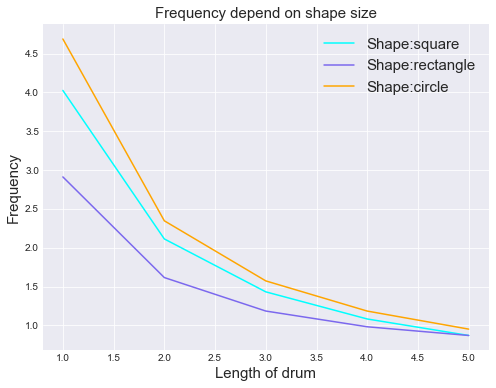

In [391]:
plt.figure(figsize=(8,6))
shapelist=["square","rectangle","circle"]
colors = ["cyan", "mediumslateblue","orange"]
for i in range(3):
    plt.plot([1, 2, 3, 4, 5],kzh.small_frequency[i],label='Shape:'+shapelist[i],color=colors[i])
plt.legend(fontsize=15)
plt.xlabel('Length of drum',size=15)
plt.title('Frequency depend on shape size',size=15)
plt.ylabel('Frequency',size=15)
plt.savefig('Smallest_shape_size.jpg',dpi=200)

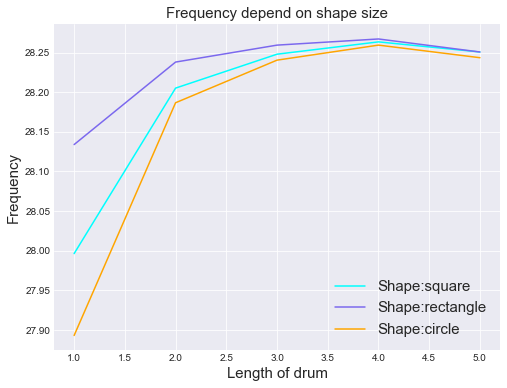

In [390]:
plt.figure(figsize=(8,6))
shapelist=["square","rectangle","circle"]
colors = ["cyan", "mediumslateblue","orange"]
for i in range(3):
    plt.plot([1, 2, 3, 4, 5],kzh.big_frequency[i],label='Shape:'+shapelist[i],color=colors[i])
plt.legend(fontsize=15)
plt.xlabel('Length of drum',size=15)
plt.title('Frequency depend on shape size',size=15)
plt.ylabel('Frequency',size=15)
plt.savefig('biggest_shape_size.jpg',dpi=200)

In [112]:
kz=drum()
kz.plot_N_f()

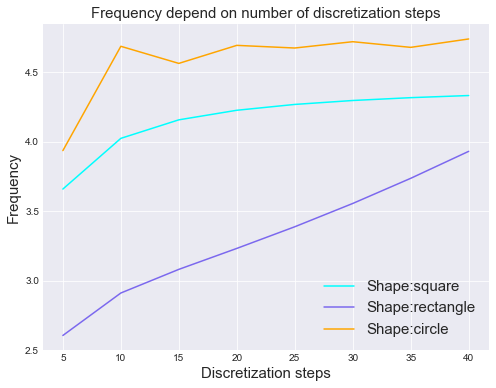

In [392]:
plt.figure(figsize=(8,6))
shapelist=["square","rectangle","circle"]
colors = ["cyan", "mediumslateblue","orange"]
for i in range(3):
    plt.plot(np.arange(5, 45, 5),kz.small_frequency[i],label='Shape:'+shapelist[i],color=colors[i])
plt.legend(fontsize=15)
plt.xlabel('Discretization steps',size=15)
plt.title('Frequency depend on number of discretization steps',size=15)
plt.ylabel('Frequency',size=15)
plt.savefig('Smallest_N.jpg',dpi=200)

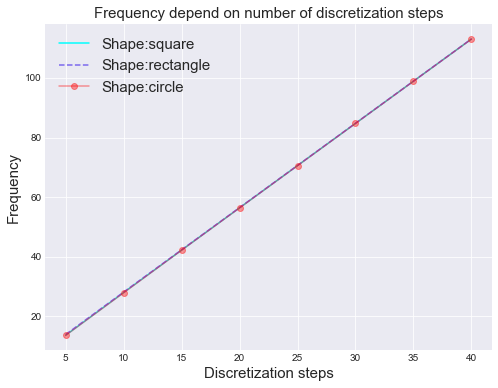

In [127]:
plt.figure(figsize=(8,6))
shapelist=["square","rectangle","circle"]
colors = ["cyan", "mediumslateblue","orange"]

plt.plot(np.arange(5, 45, 5),kz.big_frequency[0],label='Shape:'+shapelist[0],color=colors[0])
plt.plot(np.arange(5, 45, 5),kz.big_frequency[1],'--',label='Shape:'+shapelist[1],color=colors[1])
plt.plot(np.arange(5, 45, 5),kz.big_frequency[2],'go-',label='Shape:'+shapelist[2],color='red',alpha=0.4)
plt.legend(fontsize=15)
plt.xlabel('Discretization steps',size=15)
plt.title('Frequency depend on number of discretization steps',size=15)
plt.ylabel('Frequency',size=15)
plt.savefig('biggest_N.jpg',dpi=200)

0 1
1 2
2 3
3 4
4 5


<Figure size 432x288 with 0 Axes>

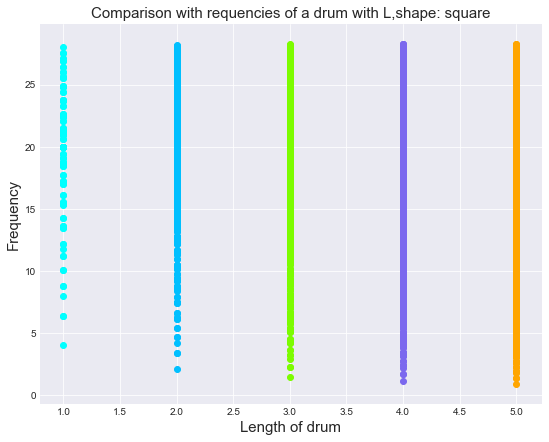

0 1
1 2
2 3
3 4
4 5


<Figure size 432x288 with 0 Axes>

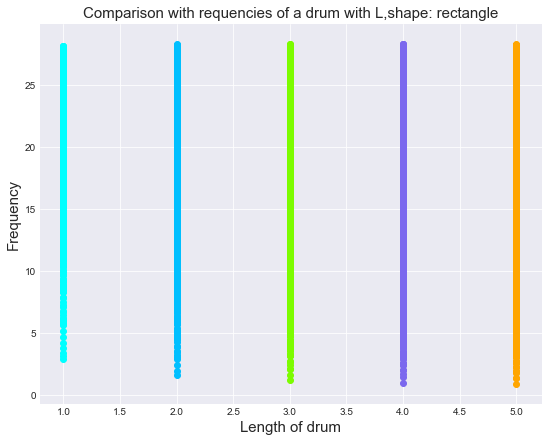

0 1
1 2
2 3
3 4
4 5


<Figure size 432x288 with 0 Axes>

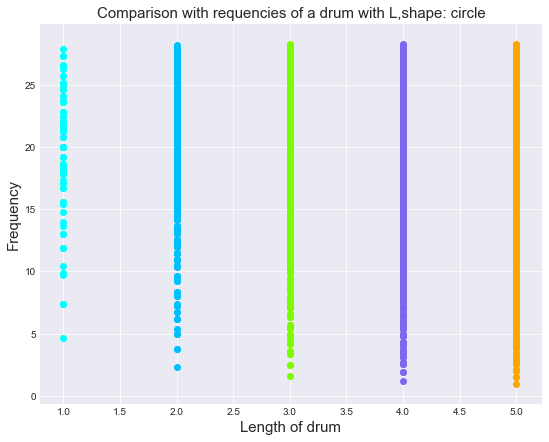

In [353]:
h=drum()
h.plot_frequency_L()

# TIME

# Square

In [89]:
time1=drum()
time1.compare_time_L()
slowlist_L_1=time1.timelist
time2=drum()
time2.compare_time_N()
slowlist_N_1=time2.timelist

In [91]:
time3=drum()
time3.compare_time_L()
quicklist_L_1=time3.timelist
time4=drum()
time4.compare_time_N()
quicklist_N_1=time4.timelist

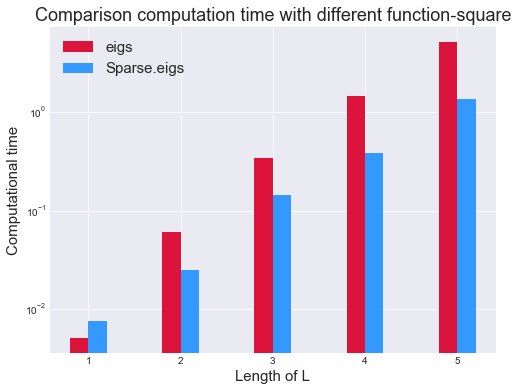

In [100]:
plt.figure(figsize=(8,6))
plt.title('Comparison computation time with different function-square',size=18)
plt.xlabel('Length of L',size=15)
plt.ylabel('Computational time',size=15)
plt.bar(np.array([1, 2, 3, 4, 5])-0.1,slowlist_L_1,width=0.2,label='eigs',color='#DC143C')
plt.bar(np.array([1, 2, 3, 4, 5])+0.1,quicklist_L_1,width=0.2,label='Sparse.eigs',color='#3399ff')
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('Computation_time_L_square.jpg',dpi=200)

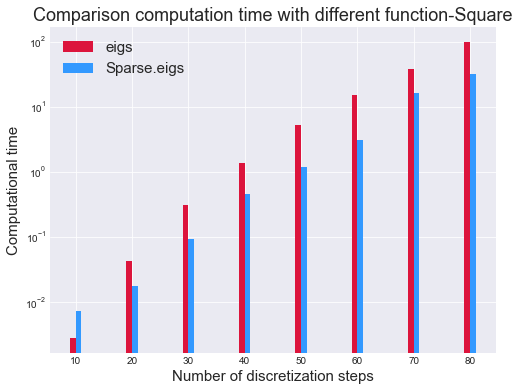

In [93]:
plt.figure(figsize=(8,6))
plt.title('Comparison computation time with different function-Square',size=18)
plt.xlabel('Number of discretization steps',size=15)
plt.ylabel('Computational time',size=15)
plt.bar(np.arange(10,90 , 10)-0.5,slowlist_N_1,width=1,label='eigs',color='#DC143C')
plt.bar(np.arange(10,90 , 10)+0.5,quicklist_N_1,width=1,label='Sparse.eigs',color='#3399ff')
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('Computation_time_discretization_steps_square.jpg',dpi=200)

# rec

In [97]:
time1_rec=drum()
time1_rec.compare_time_L()
recslowlist_L_1=time1_rec.timelist
time2_rec=drum()
time2_rec.compare_time_N()
recslowlist_N_1=time2_rec.timelist

In [99]:
time3_rec=drum()
time3_rec.compare_time_L()
recquicklist_L_1=time3_rec.timelist
time4_rec=drum()
time4_rec.compare_time_N()
recquicklist_N_1=time4_rec.timelist

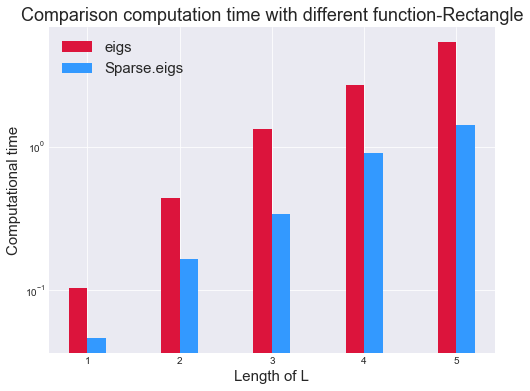

In [101]:
plt.figure(figsize=(8,6))
plt.title('Comparison computation time with different function-Rectangle',size=18)
plt.xlabel('Length of L',size=15)
plt.ylabel('Computational time',size=15)
plt.bar(np.array([1, 2, 3, 4, 5])-0.1,recslowlist_L_1,width=0.2,label='eigs',color='#DC143C')
plt.bar(np.array([1, 2, 3, 4, 5])+0.1,recquicklist_L_1,width=0.2,label='Sparse.eigs',color='#3399ff')
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('Computation_time_L_rec.jpg',dpi=200)

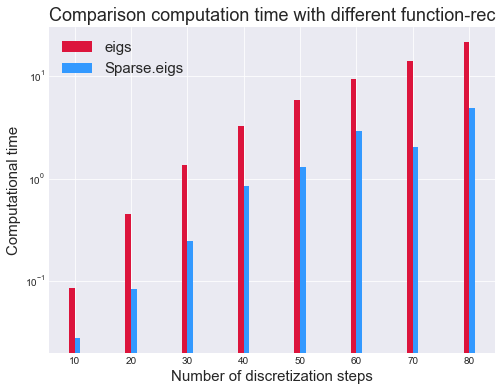

In [102]:
plt.figure(figsize=(8,6))
plt.title('Comparison computation time with different function-rec',size=18)
plt.xlabel('Number of discretization steps',size=15)
plt.ylabel('Computational time',size=15)
plt.bar(np.arange(10,90 , 10)-0.5,recslowlist_N_1,width=1,label='eigs',color='#DC143C')
plt.bar(np.arange(10,90 , 10)+0.5,recquicklist_N_1,width=1,label='Sparse.eigs',color='#3399ff')
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('Computation_time_discretization_steps_rec.jpg',dpi=200)

# circle

In [108]:
time1_cir=drum()
time1_cir.compare_time_L()
cirslowlist_L_1=time1_cir.timelist
time2_cir=drum()
time2_cir.compare_time_N()
cirslowlist_N_1=time2_cir.timelist

In [106]:
time3_cir=drum()
time3_cir.compare_time_L()
cirquicklist_L_1=time3_cir.timelist
time4_cir=drum()
time4_cir.compare_time_N()
cirquicklist_N_1=time4_cir.timelist

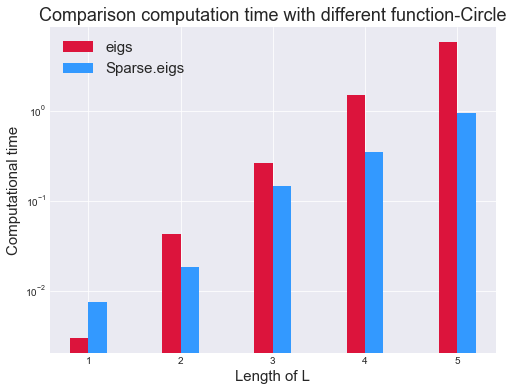

In [109]:
plt.figure(figsize=(8,6))
plt.title('Comparison computation time with different function-Circle',size=18)
plt.xlabel('Length of L',size=15)
plt.ylabel('Computational time',size=15)
plt.bar(np.array([1, 2, 3, 4, 5])-0.1,cirslowlist_L_1,width=0.2,label='eigs',color='#DC143C')
plt.bar(np.array([1, 2, 3, 4, 5])+0.1,cirquicklist_L_1,width=0.2,label='Sparse.eigs',color='#3399ff')
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('Computation_time_L_Circle.jpg',dpi=200)

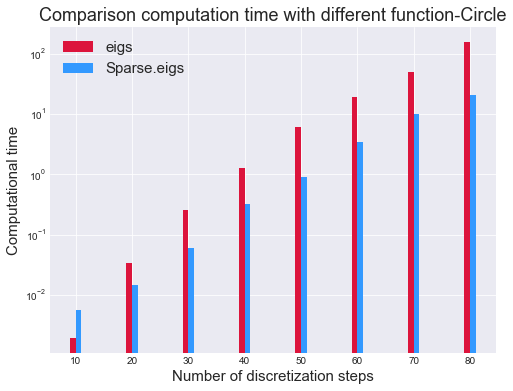

In [110]:
plt.figure(figsize=(8,6))
plt.title('Comparison computation time with different function-Circle',size=18)
plt.xlabel('Number of discretization steps',size=15)
plt.ylabel('Computational time',size=15)
plt.bar(np.arange(10,90 , 10)-0.5,cirslowlist_N_1,width=1,label='eigs',color='#DC143C')
plt.bar(np.arange(10,90 , 10)+0.5,cirquicklist_N_1,width=1,label='Sparse.eigs',color='#3399ff')
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('Computation_time_discretization_steps_Circle.jpg',dpi=200)

<Figure size 432x288 with 0 Axes>

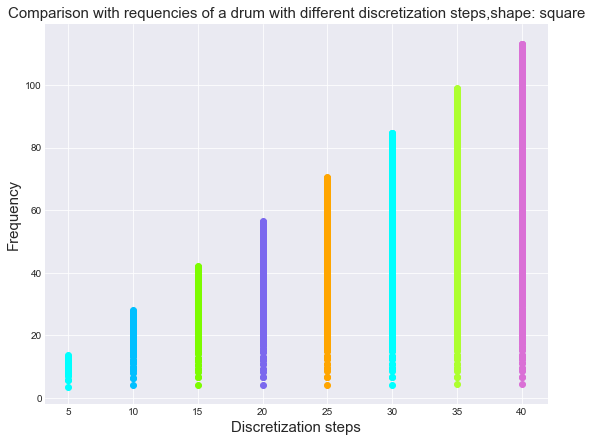

<Figure size 432x288 with 0 Axes>

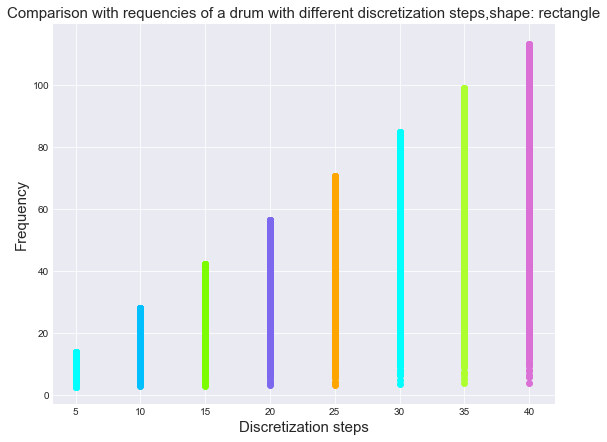

<Figure size 432x288 with 0 Axes>

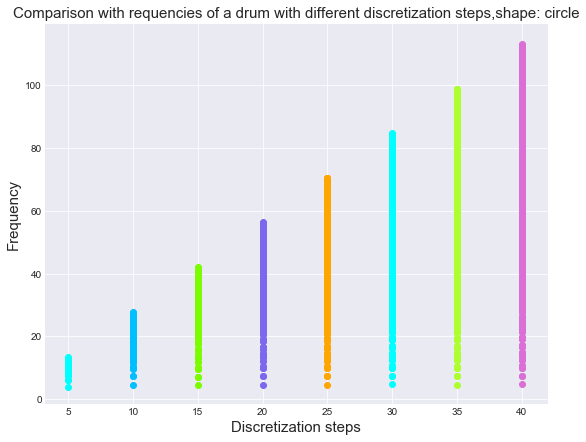

In [356]:
k=drum()
k.plot_frequency_N()

# Square

In [341]:
h=drum(shape="square")
M=h.make_square_matrix()
matrix,frequency=h.find_eigenmodes(M)

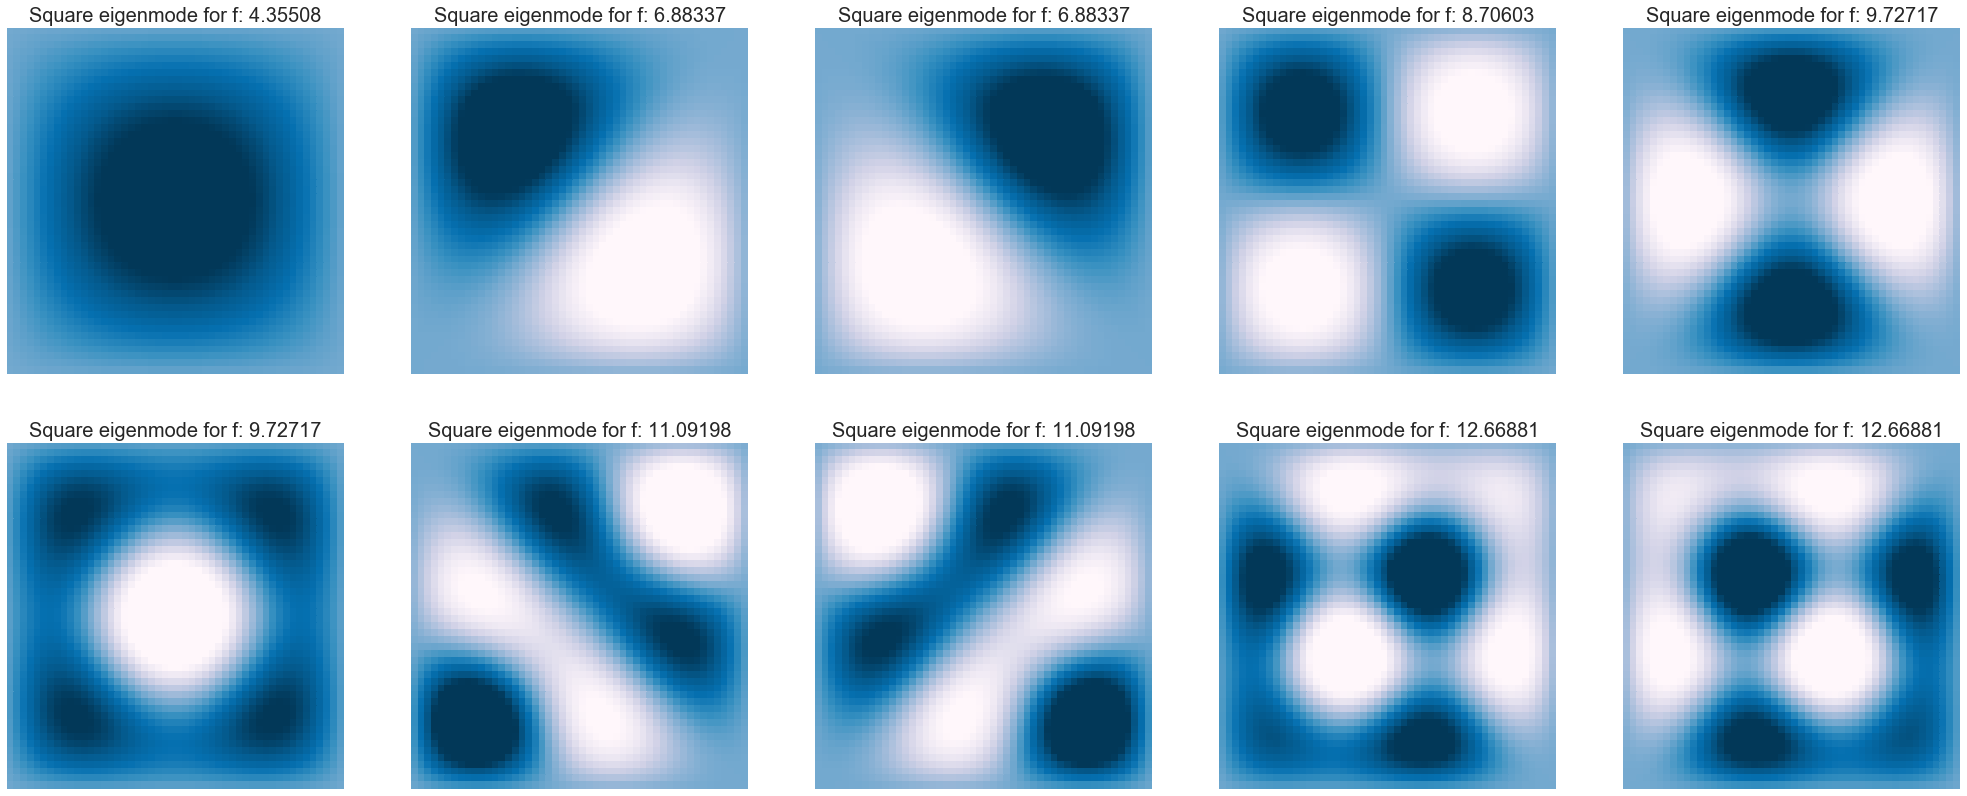

In [157]:
camp="PuBu"
plt.figure(figsize=(35,14))
plt.subplot(2,5,1)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[0]), 5)),size=20)
sns.heatmap(matrix[0], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,2)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[1]), 5)),size=20)
sns.heatmap(matrix[1], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,3)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[2]), 5)),size=20)
sns.heatmap(matrix[2], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,4)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[3]), 5)),size=20)
sns.heatmap(matrix[3], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,5)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[4]), 5)),size=20)
sns.heatmap(matrix[4], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,6)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[5]), 5)),size=20)
sns.heatmap(matrix[5], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,7)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[6]), 5)),size=20)
sns.heatmap(matrix[6], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,8)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[7]), 5)),size=20)
sns.heatmap(matrix[7], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,9)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[8]), 5)),size=20)
sns.heatmap(matrix[8], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,10)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[9]), 5)),size=20)
sns.heatmap(matrix[9], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.savefig('Square_eigenmodel.jpg',dpi=200)
plt.show()

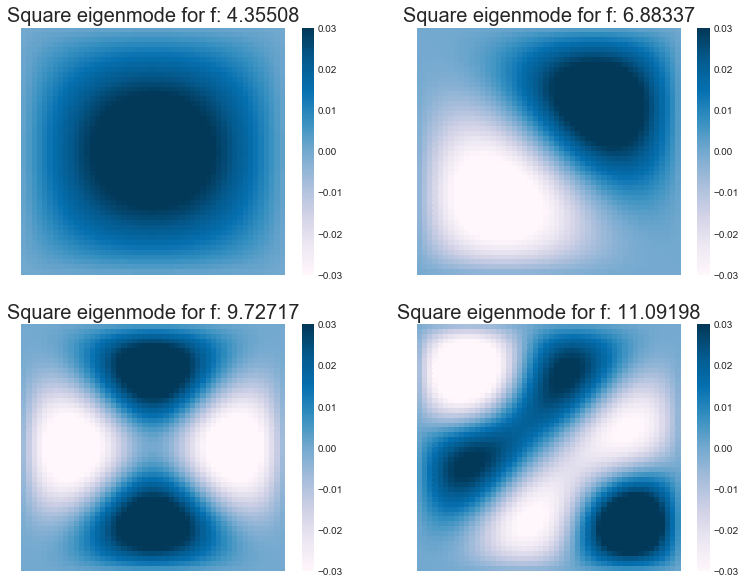

In [342]:
camp="PuBu"
plt.figure(figsize=(13,10))
plt.subplot(2,2,1)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[0]), 5)),size=20)
sns.heatmap(matrix[0], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[2]), 5)),size=20)
sns.heatmap(matrix[2], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[4]), 5)),size=20)
sns.heatmap(matrix[4], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
plt.title("Square eigenmode for f: " + str(round(abs(frequency[7]), 5)),size=20)
sns.heatmap(matrix[7], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])
plt.savefig('Square_eigenmodel_4.jpg',dpi=200)
plt.show()

# rect

In [339]:
h=drum(shape="rectangle")
M=h.make_rectangle_matrix()
matrix,frequency=h.find_eigenmodes(M)

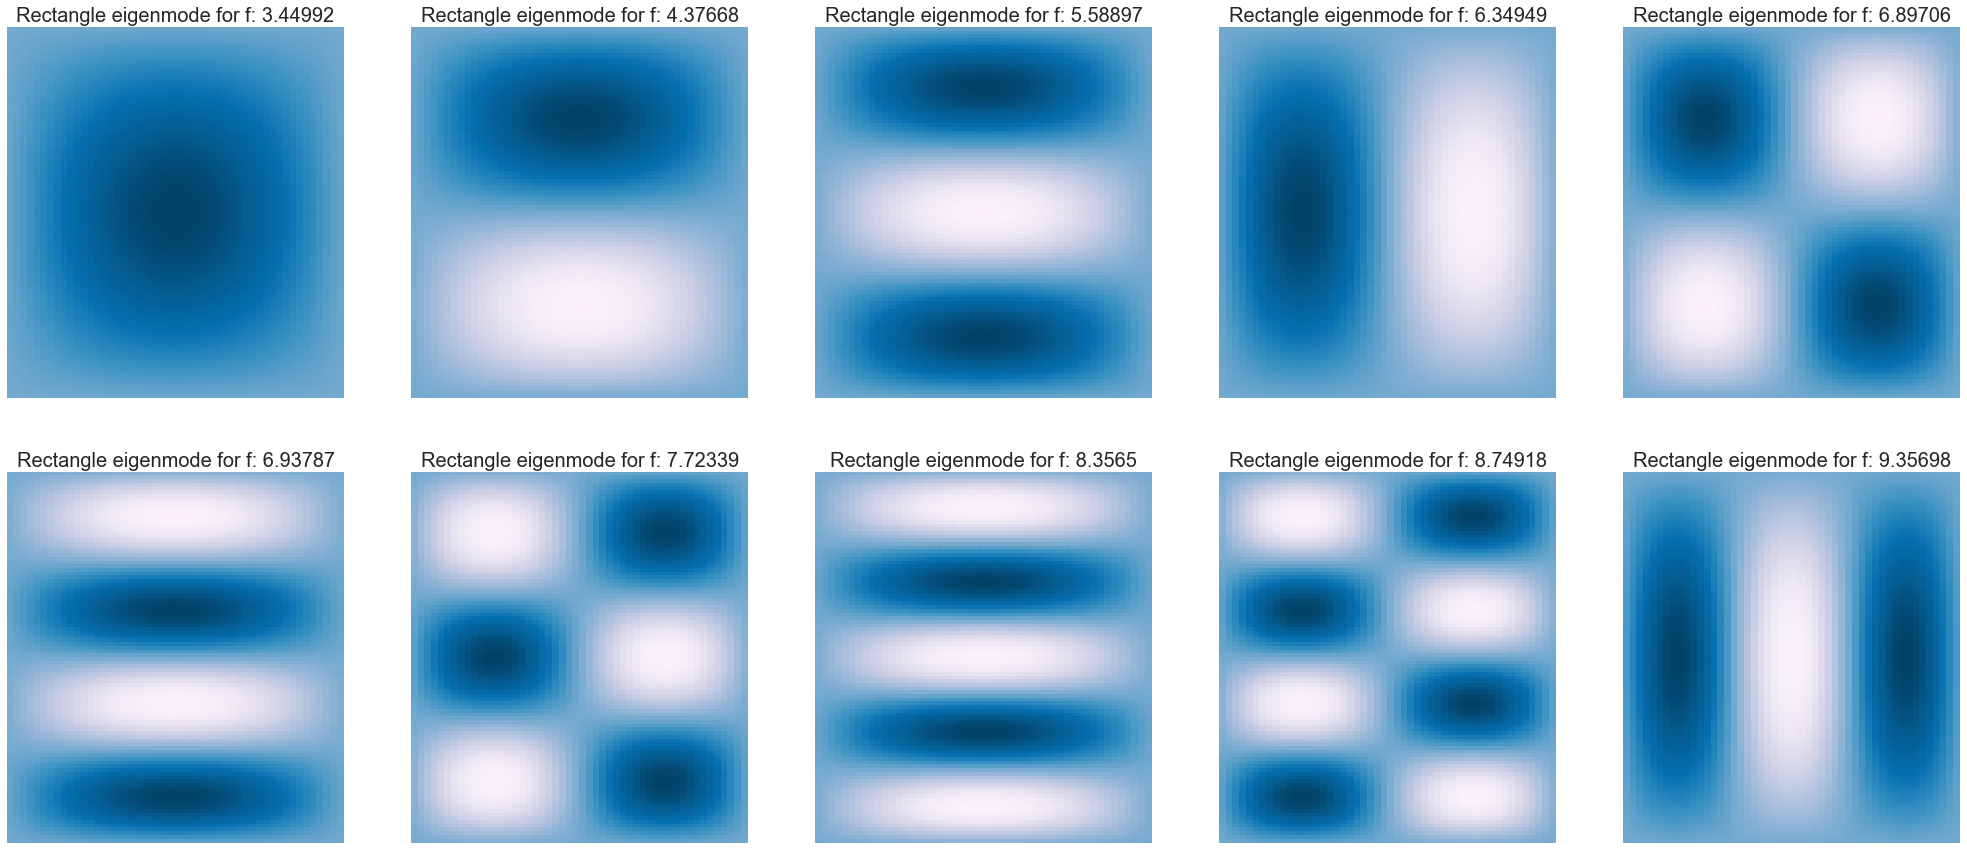

In [159]:
camp="PuBu"
plt.figure(figsize=(35,15))
plt.subplot(2,5,1)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[0]), 5)),size=20)
sns.heatmap(matrix[0], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,2)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[1]), 5)),size=20)
sns.heatmap(matrix[1], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,3)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[2]), 5)),size=20)
sns.heatmap(matrix[2], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,4)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[3]), 5)),size=20)
sns.heatmap(matrix[3], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,5)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[4]), 5)),size=20)
sns.heatmap(matrix[4], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,6)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[5]), 5)),size=20)
sns.heatmap(matrix[5], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,7)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[6]), 5)),size=20)
sns.heatmap(matrix[6], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,8)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[7]), 5)),size=20)
sns.heatmap(matrix[7], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,9)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[8]), 5)),size=20)
sns.heatmap(matrix[8], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,10)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[9]), 5)),size=20)
sns.heatmap(matrix[9], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.savefig('Rectangle_rigenmodel.jpg',dpi=200)
plt.show()

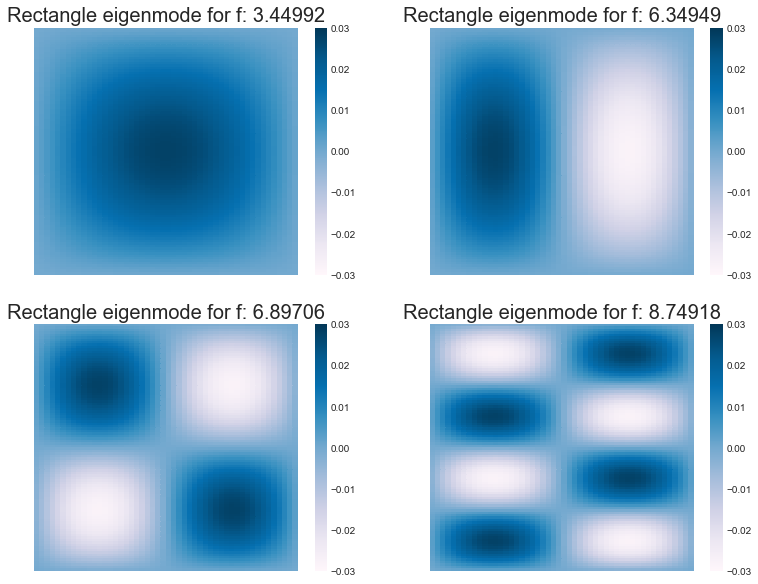

In [340]:
camp="PuBu"
plt.figure(figsize=(13,10))
plt.subplot(2,2,1)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[0]), 5)),size=20)
sns.heatmap(matrix[0], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[3]), 5)),size=20)
sns.heatmap(matrix[3], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[4]), 5)),size=20)
sns.heatmap(matrix[4], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency[8]), 5)),size=20)
sns.heatmap(matrix[8], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])
plt.savefig('Rectangle_rigenmodel_4.jpg',dpi=200)

# Circle

In [344]:
h=drum(shape="circle")
M=h.make_circle_matrix()[0]
matrix,frequency=h.find_eigenmodes(M)
# h.plot_2d(M)

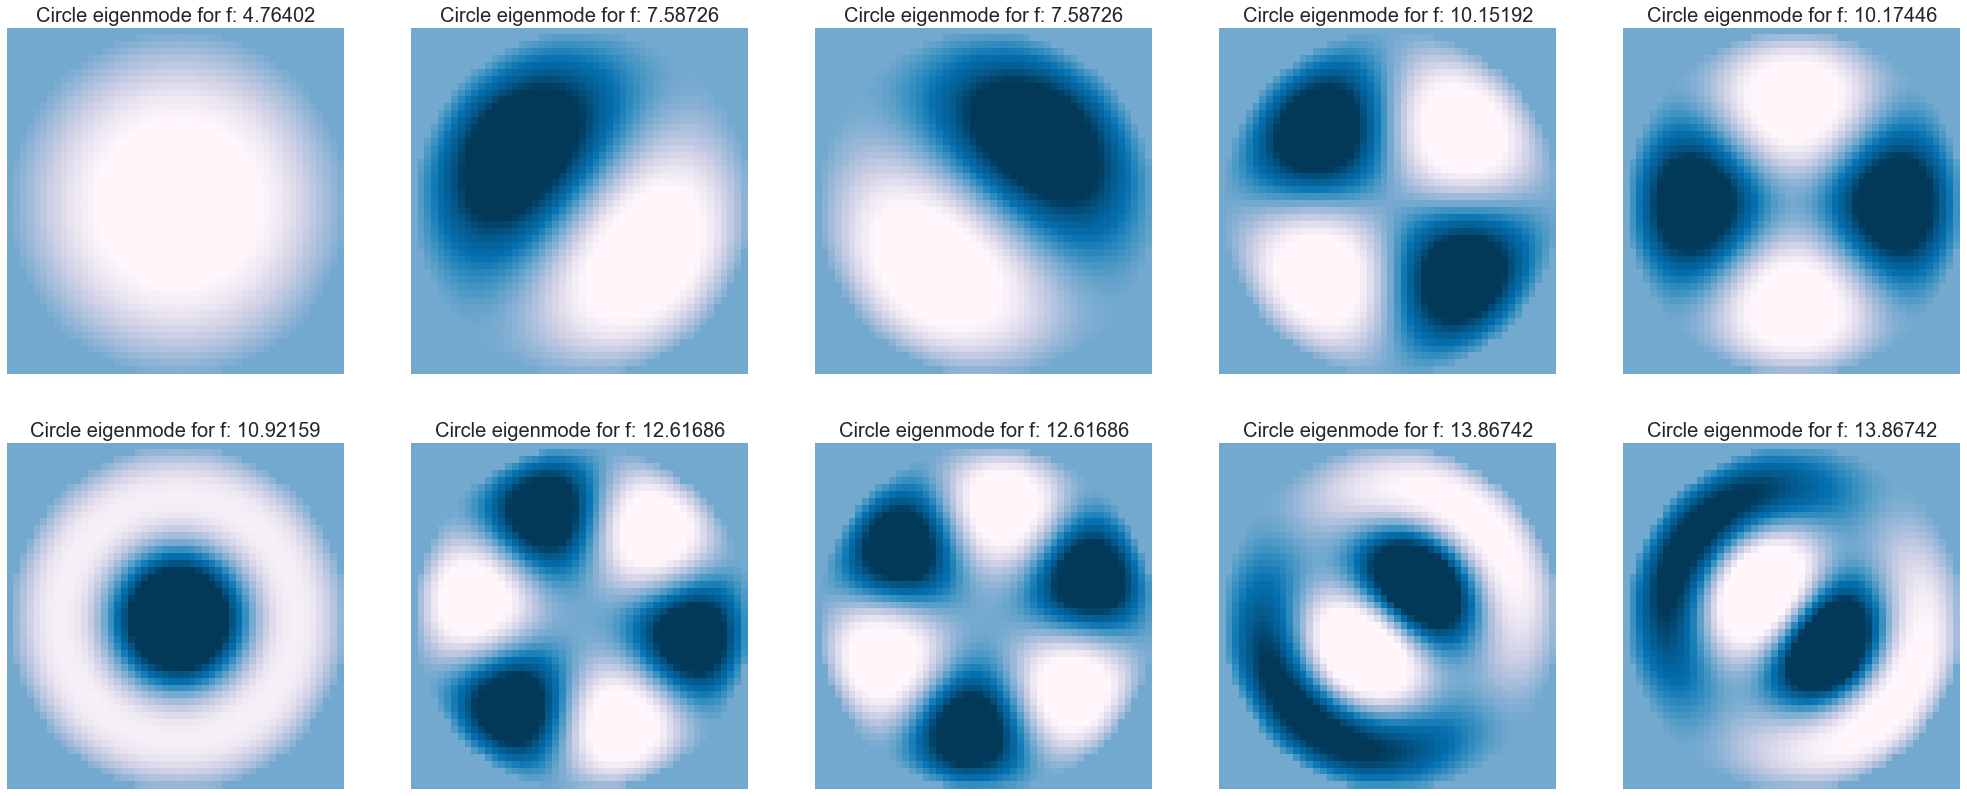

In [162]:
camp="PuBu"
plt.figure(figsize=(35,14))
plt.subplot(2,5,1)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[0]), 5)),size=20)
sns.heatmap(matrix[0], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,2)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[1]), 5)),size=20)
sns.heatmap(matrix[1], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,3)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[2]), 5)),size=20)
sns.heatmap(matrix[2], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,4)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[3]), 5)),size=20)
sns.heatmap(matrix[3], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,5)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[4]), 5)),size=20)
sns.heatmap(matrix[4], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(2,5,6)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[5]), 5)),size=20)
sns.heatmap(matrix[5], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,7)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[6]), 5)),size=20)
sns.heatmap(matrix[6], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,8)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[7]), 5)),size=20)
sns.heatmap(matrix[7], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,9)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[8]), 5)),size=20)
sns.heatmap(matrix[8], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,5,10)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[9]), 5)),size=20)
sns.heatmap(matrix[9], cmap=camp, vmin=-0.03, vmax=0.03,cbar=False)
plt.xticks([])
plt.yticks([])
plt.savefig('circle_eigenmodel.jpg',dpi=200)
plt.show()

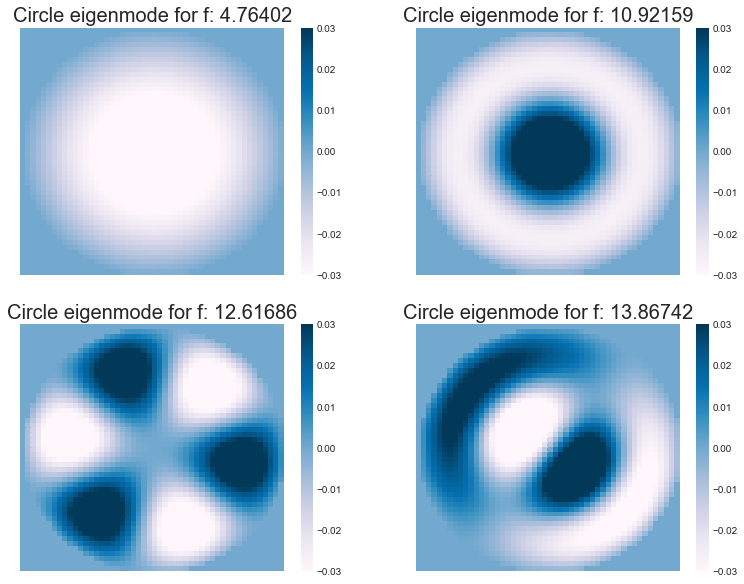

In [338]:
camp="PuBu"
plt.figure(figsize=(13,10))
plt.subplot(2,2,1)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[0]), 5)),size=20)
sns.heatmap(matrix[0], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[5]), 5)),size=20)
sns.heatmap(matrix[5], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[6]), 5)),size=20)
sns.heatmap(matrix[6], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
plt.title("Circle eigenmode for f: " + str(round(abs(frequency[9]), 5)),size=20)
sns.heatmap(matrix[9], cmap=camp, vmin=-0.03, vmax=0.03)
plt.xticks([])
plt.yticks([])
plt.savefig('circle_eigenmodel_4.jpg',dpi=200)

# 3d

In [399]:
h=drum(shape="rectangle")
M=h.make_rectangle_matrix()
_,frequency_rec=h.find_eigenmodes(M)
models=h.print_eigenmodes()
keys_rectlist=[]
for i, eigenvalue in enumerate(models):
    keys_rectlist.append(eigenvalue)

In [211]:
h=drum(shape="square")
M=h.make_rectangle_matrix()
_,frequency_square=h.find_eigenmodes(M)
square_models=h.print_eigenmodes()
keys_squarelist=[]
for i, eigenvalue in enumerate(square_models):
    keys_squarelist.append(eigenvalue)

In [212]:
h=drum(shape="circle")
M=h.make_circle_matrix()[0]
_,frequency_circle=h.find_eigenmodes(M)
circle_models=h.print_eigenmodes()
keys_circlelist=[]
for i, eigenvalue in enumerate(circle_models):
    keys_circlelist.append(eigenvalue)

# Rectangle

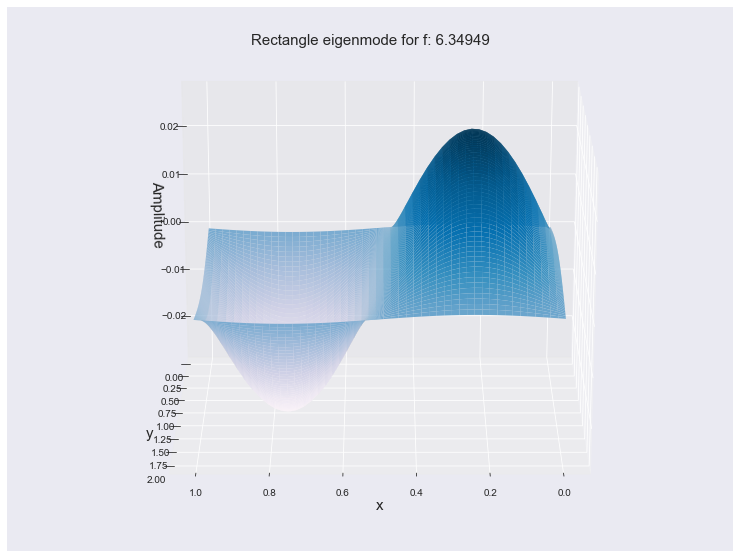

In [401]:

L=1
width=N=50
x = np.linspace(0, L, width)
y = np.linspace(0, 2*L, 2*width)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
plt.title("Rectangle eigenmode for f: " + str(round(abs(frequency_rec[3]), 5)),size=15)
ax.plot_surface(X, Y, models[keys_rectlist[3]], rstride=1, cstride=1, cmap=camp, edgecolor='none')
ax.view_init(20, 90)
ax.set_xlabel("x",size=15)
ax.set_ylabel("y",size=15)
ax.set_zlabel("Amplitude",size=15)
plt.savefig('3_D_recyangle.jpg',dpi=200,bbox_inches = 'tight')
plt.show()

# Square

<Figure size 432x288 with 0 Axes>

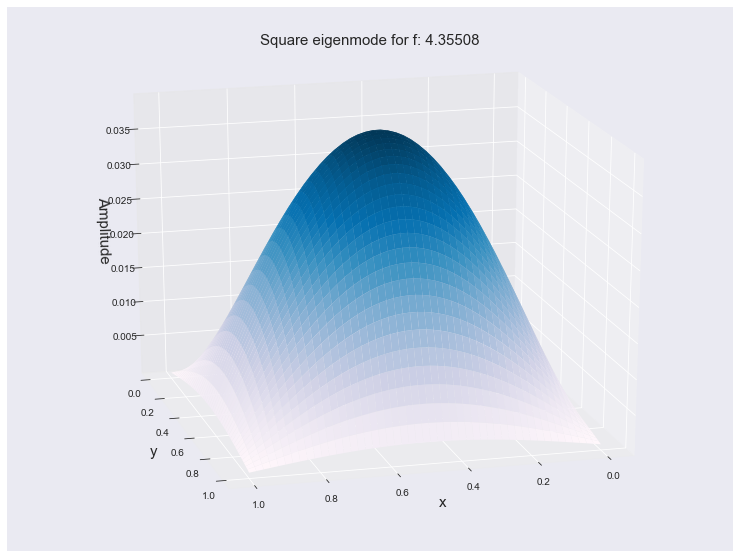

In [395]:
L=1
width=N=50
x = np.linspace(0, L, width)
y = np.linspace(0, L, width)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
plt.title("Square eigenmode for f: " + str(round(abs(frequency_square[0]), 5)),size=15)
ax.plot_surface(X, Y, square_models[keys_squarelist[0]], rstride=1, cstride=1, cmap=camp, edgecolor='none')
ax.view_init(20, 75)
ax.set_xlabel("x",size=15)
ax.set_ylabel("y",size=15)
ax.set_zlabel("Amplitude",size=15)
plt.savefig('3_D_square.jpg',dpi=200,bbox_inches = 'tight')

# circle

<Figure size 432x288 with 0 Axes>

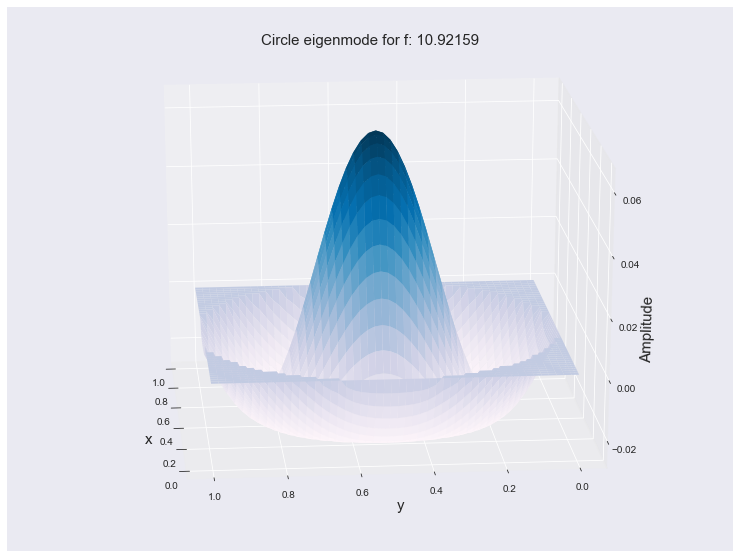

In [394]:
L=1
width=N=50
x = np.linspace(0, L, width)
y = np.linspace(0, L, width)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
plt.title("Circle eigenmode for f: " + str(round(abs(frequency_circle[5]), 5)),size=15)
ax.plot_surface(X, Y, circle_models[keys_circlelist[5]], rstride=1, cstride=1, cmap=camp, edgecolor='none')
ax.view_init(20, 175)
ax.set_xlabel("x",size=15)
ax.set_ylabel("y",size=15)
ax.set_zlabel("Amplitude",size=15)
plt.savefig('3_D_circle.jpg',dpi=200,bbox_inches = 'tight')

# Time depend

In [203]:

class time_dependet():
    def __init__(self, matrix, eigenvalue, shape):
        self.state = np.copy(matrix)
        self.prev_state = np.copy(matrix)
        self.eigenvalue = eigenvalue
        self.timestep = 0
        self.width = len(matrix)
        self.height = len(matrix[0])
        self.shape = shape
        if not shape == "rectangle":
            x = np.linspace(-0.5, 0.5, self.width)
            y = np.linspace(-0.5, 0.5, self.height)
            self.X, self.Y = np.meshgrid(x, y)
        else:
            x = np.linspace(-0.5, 0.5, self.width)
            y = np.linspace(-1, 1, self.height)
            self.X, self.Y = np.meshgrid(x, y)

    def set_circle(self, circle):
        self.circle = circle

    def prettified_current_state(self):
        """ Add zeros around the boundaries"""

        prettified = np.zeros((len(self.state) + 2,len(self.state[0]) + 2))

        for i in range(1, len(prettified) - 2):
            for j in range(1, len(prettified[0]) - 2):
                prettified[i, j] = self.state[i - 1, j - 1]

        x = np.linspace(-0.5, 0.5, self.width + 2)
        y = np.linspace(-0.5, 0.5, self.height + 2)

        X, Y = np.meshgrid(x, y)

        return X, Y, prettified

    def next_step(self):

        c = 1
        dt = 0.001
        dx = 1 / 20**2

        # copy current state first
        next_state = np.copy(self.state)
        # iterate over matrix
        for i in range(self.width - 1):
            for j in range(self.height - 1):
                if not self.shape == "circle" or self.circle[i, j] == 1:
                    # left bottom corner
                    if i == 0 and j == 0:
                        next_state[i, j] = 0

                    # right top corner
                    elif i == 0 and j == self.height - 1:
                        next_state[i, j] = 0

                    # right bottom corner
                    elif i == self.width - 1 and j == 0:
                        next_state[i, j] = 0

                    # left bottom corner
                    elif i == self.width - 1 and j == self.height - 1:
                        next_state[i, j] = 0

                    elif i == 0 and j!= self.width - 1 and j != 0: # j is not 0
                        next_state[i, j] = 0

                        
                    elif j == 0 and i!= self.width - 1 and i != 0: 
                        next_state[i, j] = 0

                        
                    elif i == self.width - 1 and j!= self.width - 1 and j != 0:
                        next_state[i, j] = 0

                    elif j == self.height - 1 and i!= self.width - 1 and i != 0:
                        next_state[i, j] = 0

                    elif j!= 0 and j!= self.height - 1 and i!= self.width - 1 and i != 0:
#                         print(i,j)
                        next_state[i, j] = (((c * dt)/ dx)** 2)* (self.state[i + 1, j] + self.state[i - 1, j]+ self.state[i, j - 1] + self.state[i, j + 1]- 4 * self.state[i, j])+ 2 * self.state[i, j] - self.prev_state[i , j]

        self.prev_state = np.copy(self.state)
        self.state = np.copy(next_state)

        self.timestep += 1

# Animation

In [216]:

def show_animation(eigenmodes,shape,circle):
    dt = 0.001
    tmax = 0.2
    timesteps = math.ceil(tmax/dt)

    # this needs to be global for the animation
    global current_state, fig, ax

    for i,eigenvalue in enumerate(eigenmodes):
        current_state = time_dependet(eigenmodes[eigenvalue], eigenvalue, shape)

        if shape == "circle":
            current_state.set_circle(circle)
        elif shape == "rectangle":
            current_state.state = current_state.state.T

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    plt.title("Vibration of eigenmode with $\lambda$: " + str(current_state.eigenvalue.real) + " timestep: " + str(current_state.timestep))
    ax.plot_surface(current_state.X, current_state.Y, current_state.state, rstride=1, cstride=1, cmap=camp, edgecolor='none')
    ax.set_xlim(0,20)
    ax.set_ylim(0,20)
    ax.set_zlim(-0.1,0.1)
    # animation
    anim = animation.FuncAnimation(fig, animate, frames=timesteps, interval=1, repeat=False)
    anim.save("Shape" + shape + str(current_state.eigenvalue.real) + ".mp4", fps=25)
    
def animate(i):
    ax.clear()
    ax.set_zlim(-0.1,0.1)

    current_state.next_step()

    X, Y, prettified_state = current_state.prettified_current_state()
    plt.title("Vibration of eigenmode with $\lambda$: " + str(round(abs(current_state.eigenvalue.real), 5)) + "timestep: " + str(current_state.timestep))
    ax.plot_surface(X, Y, prettified_state, rstride=1, cstride=1, cmap=camp, edgecolor='none')

    return plt,

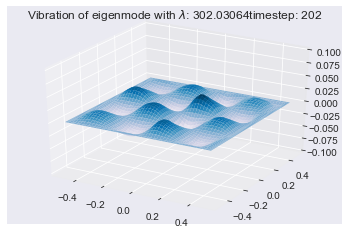

In [217]:
h=drum(shape="square")
M=h.make_square_matrix()
k,circle=h.make_circle_matrix()
h.find_eigenmodes(M)
models=h.print_eigenmodes()
show_animation(models,"square",circle)

In [218]:
h=drum(shape="circle")
M,circle=h.make_circle_matrix()
h.find_eigenmodes(M)
models=h.print_eigenmodes()

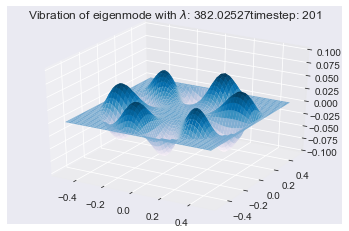

In [219]:
show_animation(models,"circle",circle)

# Direct method

In [315]:
class drict_method(object):
    def __init__(self,N=100):
        self.L=4
        self.radius=2
        self.N=N
        self.circle=np.zeros((self.N,self.N))
        self.x, self.y = math.floor(self.N/2), math.floor(self.N/2)
        self.dimension=self.N**2
        self.dx=self.L/self.N
        self.M = np.zeros((self.dimension, self.dimension))
        self.initial=np.zeros((self.N,self.N))
        
    def objectlist(self):
        
        for i, row in enumerate(self.circle):
            for j, column in enumerate(row):
                distance = (math.sqrt(abs(i - self.x)**2 + abs(j - self.y)**2))/self.N * self.L
                if distance < self.radius:
                    self.circle[i, j] = 1
        # save start of the diffusion as a different number, to use it later
        self.circle[int((0.6/2)*self.N), int((1.2/2)*self.N)] = 4
        
        
    def diffusion_matrix(self):
        self.objectlist()
        outer_diagonal = self.N
        inner_diagonal = 1
        for i in range(self.dimension):
            try:
                self.M[outer_diagonal, i] = 1
                self.M[i, outer_diagonal] = 1
            except IndexError:
                pass

            try:
                if not inner_diagonal % self.N == 0:
                    self.M[inner_diagonal, i] = 1
                    self.M[i, inner_diagonal] = 1
            except IndexError:
                pass

            outer_diagonal += 1
            inner_diagonal += 1
        np.fill_diagonal(self.M, -4)

    # multiply with constant
        self.M = (1/self.dx**2) * self.M

        for i in range(len(self.M)):
            row = math.floor(i/self.N)
            column = i % self.N
            # not in the circle or the source
            if self.circle[row, column] == 0 or self.circle[row, column] == 4:
                for j in range(len(self.M)):
                    # put a one at the diagonal so it doesn't change from being 0
                    if i == j:
                        self.M[i, j] = 1
                    else:
                        self.M[i, j] = 0

        return self.M
    
    def initial_matrix_condition(self):

        # set the source
        self.initial[int((0.6/2)*self.N), int((1.2/2)*self.N)] = 1

        # flatten the matrix, because we need the vector
        vector = self.initial.flatten()

        return vector
    
    def numfmt(self,x, pos):

    # show the final step as a 2.0 because it's pretty
        if x == 99:
            s = 2.0
        else:
            s = '{}'.format((x - 50.0)/25)

        return s

    def plot_direct(self):
        
        self.diffusion_matrix()
        
        vector=self.initial_matrix_condition()
        solution=sp.linalg.solve(self.M, vector)
        
        state=np.reshape(solution,(self.N,self.N))
        fig, ax = plt.subplots(figsize=(8, 6))
        plt.title('Direct method',size=18)
        sns.heatmap(state,cmap="twilight_r")
        ax.set_xticks([0,25,50,75,99])
        ax.set_yticks([0,25,50,75,99])
        yfmt = tkr.FuncFormatter(self.numfmt)    # create your custom formatter function
        pylab.gca().yaxis.set_major_formatter(yfmt)
        pylab.gca().xaxis.set_major_formatter(yfmt)
#         plt.savefig('Direct_method.jpg',dpi=200)
        return solution,state
        
        
        
    

[0. 0. 0. ... 0. 0. 0.]


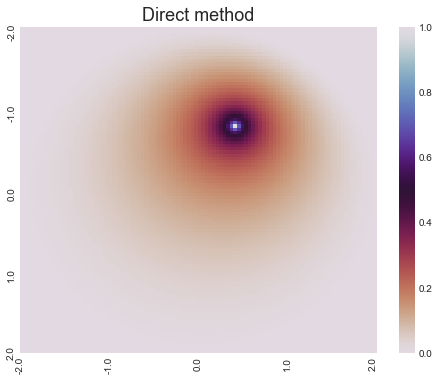

In [316]:
zzz= drict_method()
solution,state=zzz.plot_direct()

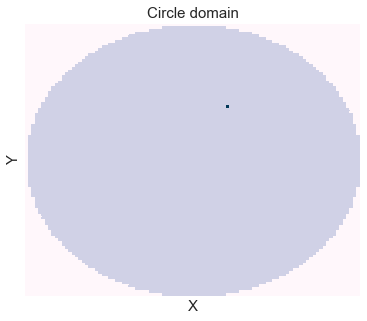

In [300]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(zzz.circle,cmap=camp,cbar=False)
plt.xticks([])
plt.yticks([])
plt.xlabel('X',size=15)
plt.ylabel('Y',size=15)
plt.title('Circle domain',size=15)
plt.savefig('Circle_domain.jpg',dpi=200)